We were testing an adaptive linear control variate that goes through the initial condition.


7.580147608619978
7.902876516910177
3.0


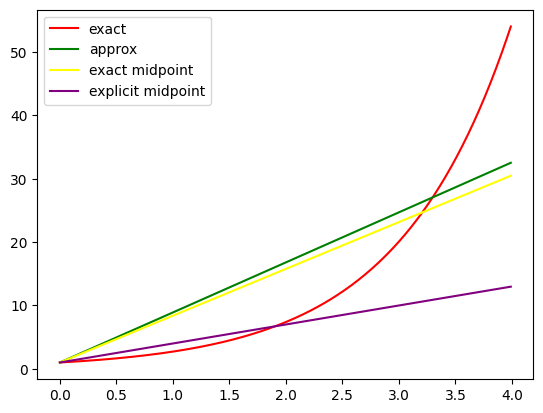

7.902876516910177


In [1]:
from random import random
import numpy as np
import matplotlib.pyplot as plt

def control(x,a): return a*x+1

def Y(t,a): 
    S = random()*t
    return 1+t +a*t**2/2 + ((Y(S,a)-control(S,a) if random()<t else 0) if t<1 else t*(Y(S,a)-control(S,a)) )

def A(t,a):
    S = random()*t  
    return a+ 3*(Y(S,a)- a*S-1)*S/t**2

t = 4
a_mid = 1+t/2
a,nsim = a_mid,10**3
for _ in range(2):
    a = sum(A(t,a) for _ in range(nsim))/nsim 
    print(a)

xs = np.arange(0,t,0.01)
ys = np.exp(xs)
zs = a*xs+1
qs  = np.exp(t/2)*xs+1
a_mid = 1+t/2
print(a_mid)
qs2 = a_mid*xs+1
plt.plot(xs,ys,color="red", label="exact")
plt.plot(xs,zs,color="green", label="approx")
plt.plot(xs,qs,color="yellow", label="exact midpoint")
plt.plot(xs,qs2,color="purple", label="explicit midpoint")

plt.legend()
plt.show()
print(a)


Ok lets try to implement a second order Monte Carlo type ODE solver based on the midpoint method.

6.914360538579073e-07


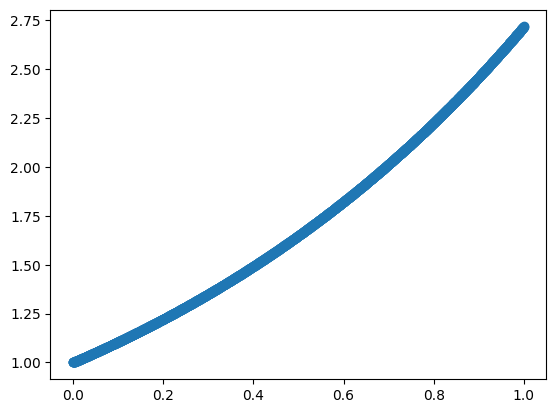

In [160]:
from random import random
from math import exp
import matplotlib.pyplot as plt

def Y_fast(t, T, yT, DT, a_mid):
    S = T + random()*(t-T)  # \sim Uniform(T,t)
    return yT + (yT-T*a_mid)*(t-T)+ a_mid*(t**2-T**2)/2 + (DT*(Y_fast(S, T, yT, DT, a_mid)- (yT + a_mid*(S-T))) if random() < (t-T)/DT else 0)

slow_points = []
def Y_slow(T, DT: "step size slow recursion"):
    TT = T-DT if T-DT > 0 else 0  # TT is where we are recursing to
    YTT = Y_slow(TT, DT) if T > 0 else 1
    a_mid = YTT + T*YTT/2
    sol = Y_fast(T, TT, YTT, T-TT, a_mid) if T > 0 else 1
    slow_points.append((T, sol))
    return sol


T, DT, nsim = 1, 0.0005, 1
sol = sum(Y_slow(T, DT) for _ in range(nsim))/nsim

x, y = zip(*slow_points)
plt.scatter(x, y)
plt.show()


The following is just a first order correction:

In [448]:
from random import random
from math import exp,pow
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

@njit(fastmath=True)
def Y_fast(t, T, yT, DT):
    S = T + random()*(t-T)  # \sim Uniform(T,t)
    sol = yT*(1 + (1-T)*(t-T)+ (t**2-T**2)/2)
    sol += (DT*(Y_fast(S, T, yT, DT) -yT*(1+S-T)) if random() < (t-T)/DT else 0)
    return sol 


@njit(fastmath=True)
def Y_slow(T, DT: "step size slow recursion"):
    y,t = 1,0
    while t<T:
        tt = t+DT if t+DT<T else T
        y = Y_fast(tt, t, y, tt-t) 
        t=tt
    return y


@njit(fastmath=True, parallel=True)
def sol(T, DT, nsim ):
    total = 0.0
    for _ in prange(nsim):
        total += Y_slow(T,DT)
    return total/nsim

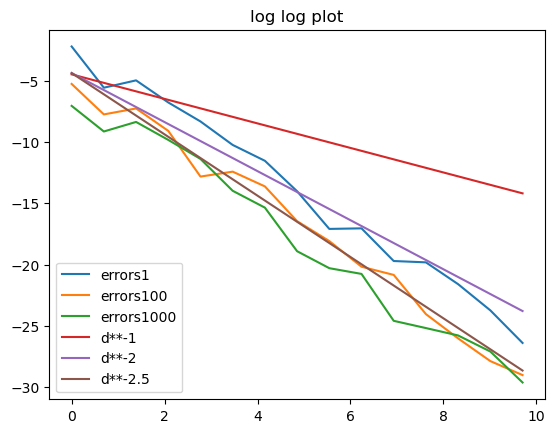

[1.09115740e-01 3.78259190e-03 6.87968355e-03 1.13528092e-03
 2.41287771e-04 3.55315885e-05 9.74992394e-06 8.14299471e-07
 3.77170227e-08 3.94967158e-08 2.75089246e-09 2.46686828e-09
 4.16093465e-10 4.91761509e-11 3.45291915e-12]
[5.14383282e-03 4.28570002e-04 6.96721103e-04 1.11866567e-04
 2.69423765e-06 4.02351858e-06 1.20788127e-06 7.09236912e-08
 1.39905946e-08 1.72668579e-09 8.86102521e-10 3.61758370e-11
 4.99234460e-12 7.85038465e-13 2.50981521e-13]
[8.59285917e-04 1.06419707e-04 2.31872608e-04 5.35432068e-05
 1.13538782e-05 8.45506659e-07 2.13865336e-07 6.11831958e-09
 1.53388102e-09 9.60986128e-10 2.09443358e-11 1.16063327e-11
 6.35146723e-12 1.71311717e-12 1.37390747e-13]


In [451]:
T = 2
#DTS = np.array([0.1,0.01,0.001,0.0001])
DTS = np.power(0.5,np.array(range(15)))
errors1 = np.array([(abs(sol(T, d, 1 )-exp(T)))/(exp(T)) for d in DTS])
errors100 = np.array([(abs(sol(T, d, 10**2 )-exp(T)))/(exp(T)) for d in DTS])
errors1000 = np.array([(abs(sol(T, d, 10**3 )-exp(T)))/(exp(T)) for d in DTS])
ref = np.array([d/89 for d in DTS])
ref2 = np.array([pow(d,2)/80 for d in DTS])
ref3 = np.array([pow(d,2.5)/80 for d in DTS])

plt.plot(-np.log(DTS),np.log(errors1), label = "errors1")
plt.plot(-np.log(DTS),np.log(errors100), label = "errors100")
plt.plot(-np.log(DTS),np.log(errors1000), label = "errors1000")
plt.plot(-np.log(DTS),np.log(ref),label ='d**-1')
plt.plot(-np.log(DTS),np.log(ref2), label="d**-2")
plt.plot(-np.log(DTS),np.log(ref3), label="d**-2.5")
plt.legend()
plt.title("log log plot")
plt.show()

print(errors1)
print(errors100)
print(errors1000)

That $2.5$ speed of convergence is weird. We will look at another ode example:
$$
y' = ty + (1 - t) e^{t}, y(0)=1.
$$ 
this has solution $e^{t}$. <br>
One way to solve this is with:
$$
y(t)= y(T) + \int_{T}^{t} (s-T) y(s) e^{(t-s)T} ds
+ \int_{T}^{t} (1-s) e^{(1-T)s} e^{tT}ds  .
$$ 
The second integral can be solved analytically, the first can be control variated either directly on $y$ or the whole integrand using information on $y$ such as $y(T)$, previous point (like multi steps), approximate derivatives by using the ODE (like Runge Kutta methods), approximate derivatives by differentiating the ODE (like Taylor methods) or by calculating estimates with worse control variates (like predictor corrector, this would an adaptive control variate). <br>

This is the straight forward integral equation:
$$
y(t)= y(T) + \int_{T}^{t} s y(s)ds + \int_{T}^{t}(1-s) e^{s}ds .
$$ 
again second integral way easier to deal with as the first.



Now lets try the stiff problem from wikipedia (https://en.m.wikipedia.org/wiki/Stiff_equation):
$$
x'= Ax, x= (1 \text{ } 0)^{T}.
$$ 
with 
$$
A = \begin{pmatrix}
0 & 1 \\
-1000 & -1001
\end{pmatrix}.
$$ 



Lets solve this first with exponential integrators:

$$
\begin{align*}
    x(t)= e^{  
    \begin{pmatrix}
    0 & 0 \\
    -1000 & -1000     
    \end{pmatrix}t 
    } x(T) +
    \int_{T}^{t} e^{\begin{pmatrix}
    0 & 0 \\
    1000 & 1000     
    \end{pmatrix}(s-t)}

    \begin{pmatrix}
    0 & 1 \\
    0 & -1        
    \end{pmatrix}
     x(s) ds 
\end{align*}
.
$$ 



In [446]:
from random import random
import numpy as np
from scipy.linalg import expm

Q = np.array([[0,0],[1000,1000]])
M = np.array([[0 ,1],[0,-1]])

def Y_fast(t, T, yT, DT):
    S = T + random()*(t-T)  # \sim Uniform(T,t)
    return np.matmul(expm(-Q*t),yT) + DT*np.matmul(expm(Q*(S-t)),np.matmul(M,Y_fast(S, T, yT, DT))) if random() < (t-T)/DT else np.matmul(expm(-Q*t),yT)


def Y_slow(T, DT: "step size slow recursion"):
    TT = T-DT if T-DT > 0 else 0  # TT is where we are recursing to
    return Y_fast(T, TT, Y_slow(TT, DT), DT) if T > 0 else np.array([1,0])

print(sum(Y_slow(1.2,0.1) for _ in range(10))/10)

[ 0.29953676 -0.29953676]


The matrix exponential is kind of annoying here note that we don't need to calculate this explicitly just an unbiased estimate of the matrix product. (maybe we search for a better way to do this later ...)

Lets now do a linear boundary problem:
$$
y''= y, y(-1)=e^{-1},y(1)=e^{1}.
$$ 
with somekind of RRMC, coupled recursion and recursion on the boundary. To turn this into an integral equation we will use green functions. We will use the green function of $y''$ on $[0,1]$ because we can because we can abuse symmetries (this is a special case of walk on spheres).

## boundary green function

$$
\begin{align*}
G''_{b0}(t) &= 0, G(0)=1,G(1)=0 \Rightarrow \\
G_{b0}(t) &= 1-t
\end{align*}
$$ 

$$
\begin{align*}
G''_{b1}(t) &= 0, G(0)=0,G(1)=1 \Rightarrow \\
G_{b1}(t) &= t
\end{align*}
$$ 

## source green function
$$
\begin{align*}
G''_{s}(t) &= \delta(t-s), G(0)=0,G(1)=0 \Rightarrow \\
G_{s}(t) &= (s-1)t \text{ if } t<s \text{ else } s(t-1)
\end{align*}
$$ 

We will do 2-phase coupled recursion with $y(-0.5),y(0.5)$ and $y(0)$ by integrating over $[-0.5,0.5]$ and $[-1,0],[0,1]$ but lets first test if the translation symmetry works by solving on these domains with exact boundaries.

In [49]:
from random import random
from math import exp

def Gb0(t): return 1-t
def Gb1(t): return t
def G(t,s): return (s-1)*t if t<s else s*(t-1)

def Y(t,b0,b1): 
    U = random()
    return Gb0(t)*b0 + Gb1(t)*b1 + (2*G(t,U) * Y(U,b0,b1) if random()<0.5 else 0)
